# Playing with sounds in AI
Lets explore the world of sound using AI.

# Start by installing requirements
pip install -r requirements.txt

In [1]:
# Imports
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from IPython.display import Audio as IPyAudio

In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
# Get the example audio file
array, sampling_rate = librosa.load(librosa.ex("trumpet"))

In [ ]:
# Listen to the audio
IPyAudio(array, rate=sampling_rate)

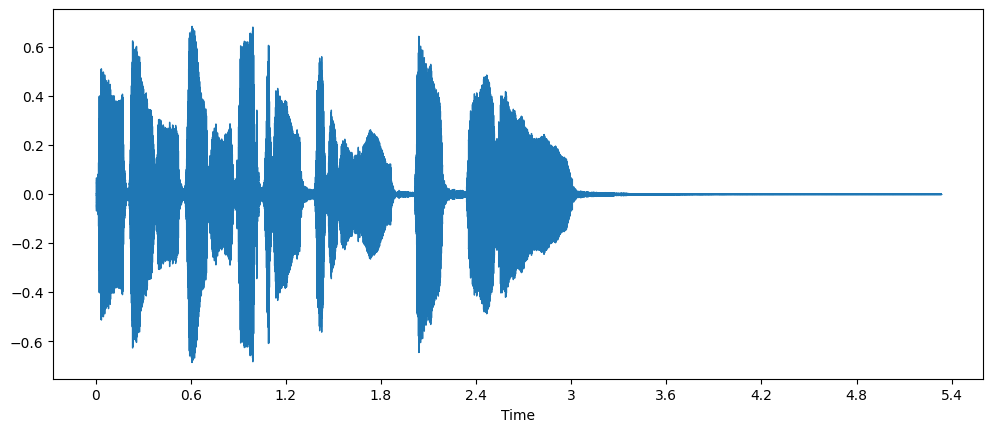

In [ ]:
# Plot the audio signal in the time domain
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

In [ ]:
# Convert the audio signal to the frequency domain using fft
samle_size = 4096
fft = np.fft.fft(array[:samle_size]) # Take the first few seconds

In [ ]:
amplitude = np.abs(fft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)
frequency = np.fft.fftfreq(len(fft), 1/sampling_rate)

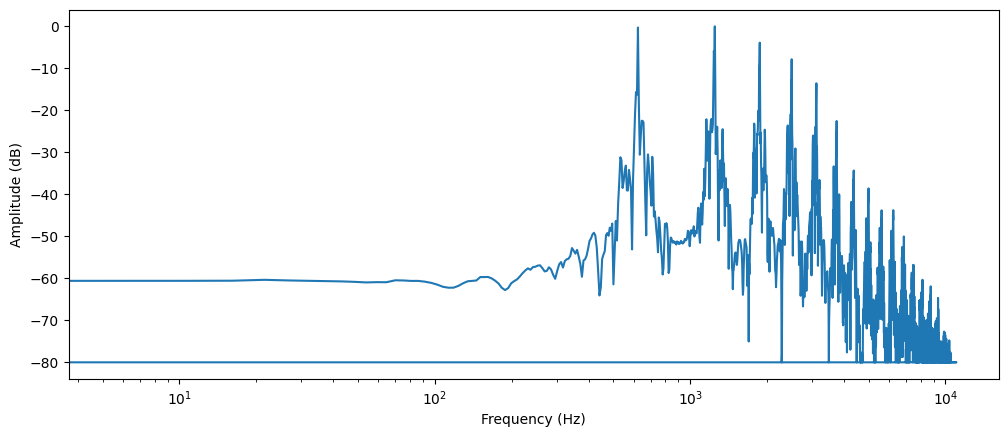

In [ ]:
plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

Text(0.5, 0, 'Frequency (Hz)')

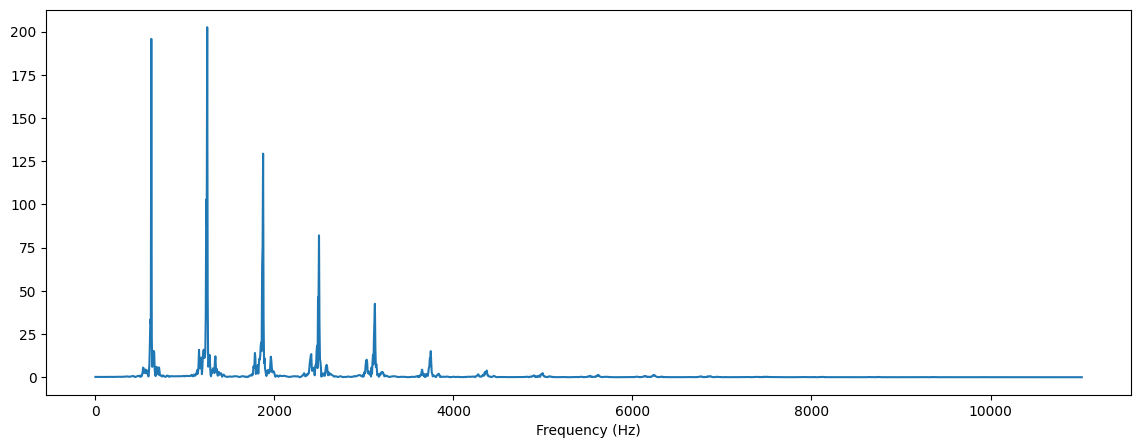

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(frequency[:len(frequency)//2], amplitude[:len(amplitude)//2])
plt.xlabel('Frequency (Hz)')

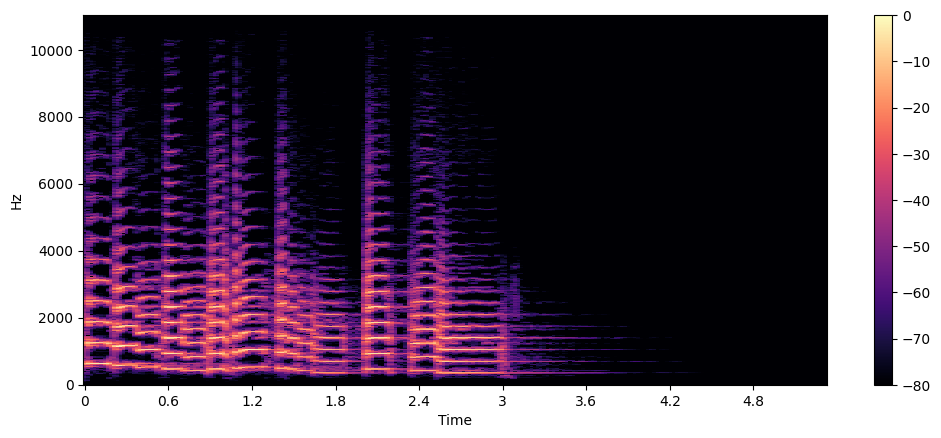

In [ ]:
# Convert the audio signal to the time-frequency domain using stft
D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

# Load data from audio dataset
Human voices from different situations

In [3]:
from datasets import load_dataset, Audio
from datasets import Dataset
import soundfile as sf
import resampy
import io

In [4]:
minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds = minds.cast_column("audio", Audio(decode=False))

In [40]:
example = minds[1]
example

{'path': 'en-AU~PAY_BILL/response_17.wav',
 'audio': {'bytes': b'RIFF2\xf8\x00\x00WAVEfmt \x12\x00\x00\x00\x07\x00\x01\x00@\x1f\x00\x00@\x1f\x00\x00\x01\x00\x08\x00\x00\x00fact\x04\x00\x00\x00\x00\xf8\x00\x00data\x00\xf8\x00\x00\xfe\xff\xff\xff\xff\xfe~~\xff\xfe\xff\xff\xff~\xff\xff\xff~\xff~~\xff\xfe\xff\xff\xff\xff\xff~\xff\xff\xff\xff\xff\xff~~\xff\xfe\xff\xfe\xff~\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff~\xff\xff\xff\xff\xfe\xff\xff\xfe\xff\xff\xff\xff\xff\xff~\xff\xff\xfe\xff\xfe\xff\xfe\xff\xff~\xff\xff\xff\xff~~\xff\xff\xff\xfe\xff\xff\xff~\xff\xfe\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xfe\xff\xff\xff\xfe\xff\xff\xff\xff\xff\xff\xff\xff\xff\xfe\xff\xff\xff\xfe\xfe~\xff\xff~\xff~\xfe\xff\xff\xff\xfe\xff\xfe\xfe\xff\xff\xff~\xff\xff\xfe~\xfe~\xff~\xfe~\xff\xff\xff\xfeyzy~{v\xff\xfbxy\xfe\xfa\xfb}\xf6\xf9}\xfb\xfc\xfa\xffy\xfc\xfa\xfe}|\xfc\xfcz}\xfd\xff{z\xfe\xfe|\xff\xfe}~||}~zx}\xfa\xff\xfb\xf5\xf6\xfe~\xf7\xfby\xfe\xf9\xfc{{\xf6\xf9{}\xfd{wx\xfe}z~\xfd\xfe{}\xf

In [31]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [41]:
audio_bytes = example["audio"]["bytes"] # raw audio bytes
IPyAudio(data=audio_bytes)

In [49]:
# Upsample the audio to 16kHz
x, sr = sf.read(io.BytesIO(audio_bytes), dtype="float32")  # sr should be 8000
print(f"Original sampling rate: {sr} Hz")
print(f"Shape of x: {x.shape}")

Original sampling rate: 8000 Hz
Shape of x: (63488,)


In [52]:
# upsample 8k -> 16k
x16 = resampy.resample(x, sr, 16000)
print(f"Shape of x16: {x16.shape}")
IPyAudio(x16, rate=16000)


Shape of x16: (126976,)


In [54]:
librosa.get_duration(y=x, sr=sr)

7.936

In [5]:
from tqdm import tqdm

In [6]:
minds_upsampled_16kHz = []
sampling_rate = 16000
print(f"Processing audio samples. Number of samples: {len(minds)}")
for sample in tqdm(minds):
    audio_bytes = sample["audio"]["bytes"]
    x, sr = sf.read(io.BytesIO(audio_bytes), dtype="float32")
    duration = librosa.get_duration(y=x, sr=sr)
    #print(f"Duration: {duration:.2f} seconds")
    if duration < 20.0:
        # Not above 20 seconds, lets keep it.
        
        #Upsample to 16kHz
        x16 = resampy.resample(x, sr, sampling_rate)

        # Save the upsampled audio back to bytes
        out_bytes = io.BytesIO()
        sf.write(out_bytes, x16, sampling_rate, format="WAV")
        out_bytes.seek(0)
        sample["audio"]["bytes"] = out_bytes.read()
        sample["audio"]["duration"] = librosa.get_duration(y=x16, sr=sampling_rate)
        # also dd the float array
        sample["audio"]["array"] = x16
        sample["audio"]["sampling_rate"] = sampling_rate
        minds_upsampled_16kHz.append(sample)

#Convert it back to a Dataset

minds_upsampled_16kHz_dataset = Dataset.from_list(minds_upsampled_16kHz)
print(f'Done, number of samples in the upsampled dataset: {len(minds_upsampled_16kHz_dataset)}')

Processing audio samples. Number of samples: 654


100%|██████████| 654/654 [00:34<00:00, 18.76it/s]


Done, number of samples in the upsampled dataset: 624


# Use Whisper to extract features from the audio

In [91]:
from transformers import WhisperFeatureExtractor, AutoProcessor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
processor = AutoProcessor.from_pretrained("openai/whisper-small")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [7]:
example = minds_upsampled_16kHz_dataset[0]
features = feature_extractor(example["audio"]["array"], sampling_rate=example["audio"]["sampling_rate"], padding=True)

NameError: name 'feature_extractor' is not defined

In [ ]:
features

{'input_features': array([[[-0.6273267 , -0.47130227,  0.01015866, ..., -0.16456044,
         -0.03012216, -0.5220679 ],
        [-0.6273267 , -0.37564695,  0.26789516, ...,  0.37743223,
          0.07729191, -0.03753185],
        [-0.6273267 , -0.33483446,  0.42834342, ...,  0.6397095 ,
          0.38259923,  0.07102591],
        ...,
        [-0.6273267 , -0.6273267 , -0.6273267 , ..., -0.6273267 ,
         -0.6273267 , -0.6273267 ],
        [-0.6273267 , -0.6273267 , -0.6273267 , ..., -0.6273267 ,
         -0.6273267 , -0.6273267 ],
        [-0.6273267 , -0.6273267 , -0.6273267 , ..., -0.6273267 ,
         -0.6273267 , -0.6273267 ]]], shape=(1, 80, 780), dtype=float32)}

In [ ]:
# Add the features to the dataset
def add_features(sample):
    features = feature_extractor(sample["audio"]["array"], sampling_rate=sample["audio"]["sampling_rate"], padding=True)
    sample["input_features"] = features.input_features[0] # Get the first (and only) element from the batch
    return sample

In [ ]:
minds_upsampled_16kHz_dataset = minds_upsampled_16kHz_dataset.map(add_features)

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

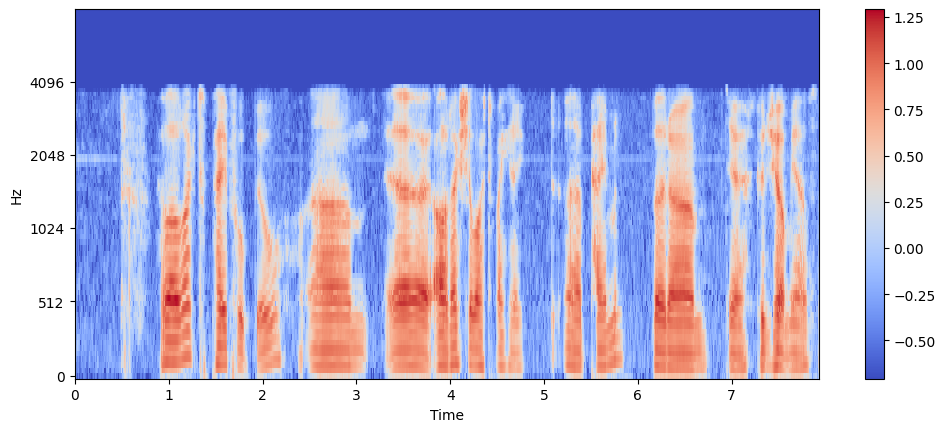

In [ ]:
example = minds_upsampled_16kHz_dataset[1]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.array(input_features),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

# Test pretrained classifier model
There are some pretrained classifiers for this dataset. Lets first try it out.

In [9]:
from transformers import pipeline

classifier = pipeline(
    "audio-classification",
    model="anton-l/xtreme_s_xlsr_300m_minds14",
)

Device set to use cuda:0


In [10]:
input = np.array(example["audio"]["array"])
print(f"Input shape: {input.shape}")
#type:
print(f"Input type: {type(input)}")
classifier(input)

Input shape: (124830,)
Input type: <class 'numpy.ndarray'>


[{'score': 0.9631527662277222, 'label': 'pay_bill'},
 {'score': 0.028196843340992928, 'label': 'freeze'},
 {'score': 0.003278736025094986, 'label': 'card_issues'},
 {'score': 0.0019414385315030813, 'label': 'abroad'},
 {'score': 0.0008378672064282, 'label': 'high_value_payment'},
 {'score': 0.0007442865753546357, 'label': 'direct_debit'},
 {'score': 0.00040225585689768195, 'label': 'latest_transactions'},
 {'score': 0.00033915197127498686, 'label': 'joint_account'},
 {'score': 0.00033119251020252705, 'label': 'balance'},
 {'score': 0.0003284234262537211, 'label': 'address'},
 {'score': 0.00014754974108655006, 'label': 'app_error'},
 {'score': 0.00014689110685139894, 'label': 'atm_limit'},
 {'score': 8.78840874065645e-05, 'label': 'cash_deposit'},
 {'score': 6.48120476398617e-05, 'label': 'business_loan'}]

# Test a model to transcribe audio to text
English text, but pre-trained

In [11]:
from transformers import pipeline

asr = pipeline("automatic-speech-recognition")

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 22aad52 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json: 0.00B [00:00, ?B/s]

c:\Users\cerion\miniconda3\envs\datascience_3.12\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cerion\.cache\huggingface\hub\models--facebook--wav2vec2-base-960h. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

Device set to use cuda:0


In [14]:
example

{'path': 'en-AU~PAY_BILL/response_4.wav',
 'audio': {'array': [2.063424290099647e-05,
   0.0001943783718161285,
   0.00022419339802581817,
   1.4444347470998764e-05,
   -0.00022495990560855716,
   -0.00022556513431482017,
   -1.8584443751024082e-05,
   0.00010950014984700829,
   1.8411776181892492e-05,
   -0.00010028613905888051,
   -1.8889684724854305e-05,
   0.0001897581241792068,
   0.000264329049969092,
   0.00012986044748686254,
   -2.2395141058950685e-05,
   -3.308166560600512e-05,
   2.549414239183534e-05,
   1.9036711819353513e-05,
   -2.9357130188145675e-05,
   -1.7947379092220217e-05,
   3.3744519896572456e-05,
   2.315804704267066e-05,
   -3.8319078157655895e-05,
   -3.419815402594395e-05,
   4.267082113074139e-05,
   5.358268754207529e-05,
   -4.635110599338077e-05,
   -9.133610728895292e-05,
   4.891294884146191e-05,
   0.0002268334646942094,
   0.0001941872324096039,
   -3.545012805261649e-05,
   -0.00019498670008033514,
   -0.00014390757132787257,
   -4.631420597434044e-

In [15]:
output = asr(input)
print(output)
print(f"Actual text: {example['english_transcription']}")

{'text': 'I WOULD LIKE TO PAY MY ELECTRICITY BILL USING MY COD CAN YOU PLEASE ASSIST'}
Actual text: I would like to pay my electricity bill using my card can you please assist
